<a href="https://colab.research.google.com/github/EHaarer/Translating-Pedestrian-Indoor-Images-into-Maps/blob/main/AdvCV_Depth_Estimation_w_LiDAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision filterpy timm lap
!pip install --upgrade scipy
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4.weights -O yolov4.weights
!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg -O yolov4.cfg

import matplotlib
matplotlib.use('Agg')

!git clone https://github.com/abewley/sort.git || echo "SORT directory already exists"
!sed -i 's/matplotlib.use(.TkAgg.)/# matplotlib.use("TkAgg")/' /content/sort/sort.py

import sys
sys.path.append('/content/sort')

import cv2
import numpy as np
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from IPython.display import Image as DisplayImage, display
from scipy import stats
import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64

Mode depth: 176
Distance: 12.777000000000015, Angle: 7.316798941798942
Mode depth: 172
Distance: 14.067399999999992, Angle: -7.134259259259259
Mode depth: 161
Distance: 18.391500000000008, Angle: -0.1521164021164021


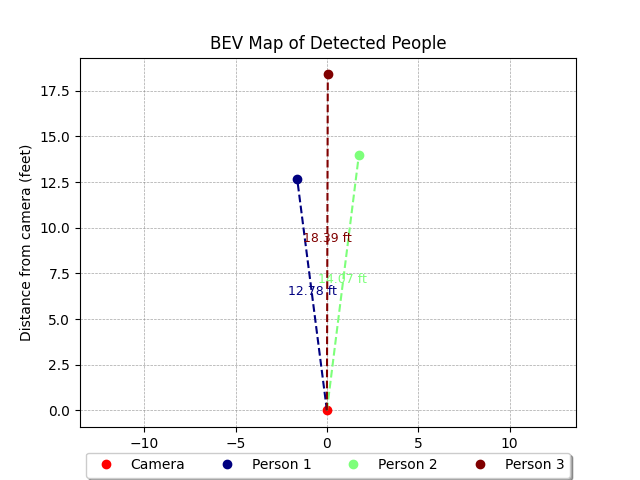

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

yolo_cfg = '/content/yolov4.cfg'
yolo_weights = '/content/yolov4.weights'
net = cv2.dnn.readNetFromDarknet(yolo_cfg, yolo_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

def apply_nms(boxes, scores, confidence_threshold=0.5, nms_threshold=0.4):
    indices = cv2.dnn.NMSBoxes(boxes, scores, confidence_threshold, nms_threshold)
    if len(indices) == 0:
        return []
    indices = indices.flatten()
    return [boxes[i] for i in indices]

def process_image(image_path, depth_map_path):
    image = cv2.imread(image_path)
    depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    Height, Width = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    detections = net.forward(net.getUnconnectedOutLayersNames())

    boxes = []
    confidences = []
    for output in detections:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if classID == 0 and confidence > 0.5:  # Detecting person
                box = detection[0:4] * np.array([Width, Height, Width, Height])
                centerX, centerY, width, height = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
    boxes = apply_nms(boxes, confidences)
    return image, depth_map, boxes


def line_of_best_fit(x):
    return 0.0047 * x**2 - 1.9582 * x + 211.833

#Miscalculation, not enough var
# def line_of_best_fit(x):
#     return 0.0061 * x**2 - 2.3763 * x + 243.92

#Used for all points, even bad data
# def line_of_best_fit(x):
#     return 0.00090172 * x**2 - 0.030892 * x + 42.5197

# Below best fit line was calculated with 5-degree polynomial before the removal of outliers from best-fit calculation
# def line_of_best_fit(x):
# # Coefficients of the polynomial terms after combining like terms
#     a5 = (-8.94e-8 - 9.06e-8)
#     a4 = (6.11e-5 + 6.24e-5)
#     a3 = (-0.01587 - 0.01634)
#     a2 = (1.93 + 2.01)
#     a1 = (-107.8 - 114.67)
#     a0 = (2198.37 + 2434.88)

# # Polynomial equation
#     y = a5 * x**5 + a4 * x**4 + a3 * x**3 + a2 * x**2 + a1 * x + a0

# # Divide by 2 and take the absolute value
#     y = abs(y / 2)

#     return y


# def calculate_polar_coordinates(boxes, depth_map, image_width):
#     mode_depths = []
#     angles = []
#     polar_coordinates = []

#     for box in boxes:
#         x, y, w, h = box
#         cropped_depth_map = depth_map[y:y+h, x:x+w]
#         mode_depth = stats.mode(cropped_depth_map, axis=None).mode[0]
#         mode_depths.append(mode_depth)

#         centerX = x + w // 2
#         angle = ((centerX - image_width / 2) / (image_width / 2)) * 23
#         angles.append(angle)

#         color_point1 = 214  # Gray color at 9 feet
#         color_point2 = 173  # Gray color at 12 feet
#         feet_point1 = 9
#         feet_point2 = 12

#         distance = ((mode_depth - color_point2) * (feet_point1 - feet_point2) /
#                     (color_point1 - color_point2) + feet_point2)
#         polar_coordinates.append((distance, angle))

#     return polar_coordinates

def calculate_polar_coordinates(boxes, depth_map, image_width):
    mode_depths = []
    angles = []
    polar_coordinates = []

    for box in boxes:
        x, y, w, h = box
        if w > 0 and h > 0:  # Ensure the box has area
            cropped_depth_map = depth_map[y:y+h, x:x+w]
            mode_result = stats.mode(cropped_depth_map.ravel(), axis=None)  # Flatten the array to ensure no issues with dimensions
            if mode_result.mode.size > 0:
                mode_depth = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode
                print(f"Mode depth: {mode_depth}")
            else:
                continue  # Skip this box if no mode could be found
        else:
            continue  # Skip this box if it has no area

        mode_depths.append(mode_depth)

        centerX = x + w // 2
        # angle = ((centerX - image_width / 2) / (image_width / 2)) * 23
        angle = ((centerX - image_width / 2) / (image_width / 2)) * -23         # the half angle here is 45/2 * -1 to account for correst FOV and orientation. For a given Camera, replace this with (FOV of Pic / 2) * -1
        #angle = ((centerX - image_width / 2) / (image_width / 2)) * -40        # ie portrait mode = -23, and regular photos from an iPhone 12 pro would be = -40
        angles.append(angle)

        # Distance calculation using linear interpolation
        # color_point1 = 214  # Gray color at 9 feet
        # color_point2 = 173  # Gray color at 12 feet
        # feet_point1 = 9
        # feet_point2 = 12

        # distance = ((mode_depth - color_point2) * (feet_point1 - feet_point2) /
        #             (color_point1 - color_point2) + feet_point2)

        distance = line_of_best_fit(mode_depth)

        polar_coordinates.append((distance, angle))
        print(f"Distance: {distance}, Angle: {angle}")

    return polar_coordinates

#The original plotting, no legend
# def plot_top_down_map(polar_coordinates):
#     fig, ax = plt.subplots()
#     camera_position = (0, 0)
#     ax.plot(camera_position[0], camera_position[1], 'ro', label='Camera')

#     for distance, angle in polar_coordinates:
#         x = distance * math.cos(math.radians(angle + 90))
#         y = distance * math.sin(math.radians(angle + 90))
#         ax.plot(x, y, 'bo')

#     ax.set_xlabel('Distance from camera (feet)')
#     ax.set_ylabel('Distance from camera (feet)')
#     plt.axis('equal')
#     plt.title('BEV Map of Detected People')

#     ax.grid(True)
#     ax.legend()

#     plt.savefig('bev_map.png')
#     plt.close(fig)
#     display(DisplayImage(filename='bev_map.png'))

#Graph with grid lines, legend
# def plot_top_down_map(polar_coordinates):
#     fig, ax = plt.subplots()
#     camera_position = (0, 0)
#     ax.plot(camera_position[0], camera_position[1], 'ro', label='Camera')

#     # Generate unique colors for each person detected
#     colors = plt.cm.jet(np.linspace(0, 1, len(polar_coordinates)))

#     for i, (distance, angle) in enumerate(polar_coordinates):
#         # Rotate points by 90 degrees counterclockwise
#         x = distance * math.cos(math.radians(angle + 90))
#         y = distance * math.sin(math.radians(angle + 90))
#         # Plot each person with a unique color and label
#         ax.plot(x, y, 'o', color=colors[i], label=f'Person {i + 1}')

#     ax.set_xlabel('Distance from camera (feet)')
#     ax.set_ylabel('Distance from camera (feet)')
#     plt.axis('equal')
#     plt.title('BEV Map of Detected People')

#     # Adding grid lines to the plot
#     ax.grid(True)  # Enable grid
#     ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

#     # Add a legend outside the plot area
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

#     plt.savefig('bev_map.png')
#     plt.close(fig)
#     display(DisplayImage(filename='bev_map.png'))

#Plot graph with radial lines to denote distance from camera to each point
def plot_top_down_map(polar_coordinates):
    fig, ax = plt.subplots()
    camera_position = (0, 0)
    ax.plot(camera_position[0], camera_position[1], 'ro', label='Camera')

    # Generate unique colors for each person detected
    colors = plt.cm.jet(np.linspace(0, 1, len(polar_coordinates)))

    for i, (distance, angle) in enumerate(polar_coordinates):
        # Rotate points by 90 degrees counterclockwise
        x = distance * math.cos(math.radians(angle + 90))
        y = distance * math.sin(math.radians(angle + 90))
        # Plot each person with a unique color and label
        ax.plot(x, y, 'o', color=colors[i], label=f'Person {i + 1}')

        # Draw line from camera to the person
        ax.plot([camera_position[0], x], [camera_position[1], y], color=colors[i], linestyle='dashed')

        # Annotate the line with the distance
        midpoint = ((x + camera_position[0]) / 2, (y + camera_position[1]) / 2)
        ax.text(midpoint[0], midpoint[1], f'{distance:.2f} ft', color=colors[i], fontsize=9, ha='center')

    ax.set_xlabel('Distance from camera (feet)')
    ax.set_ylabel('Distance from camera (feet)')
    plt.axis('equal')
    plt.title('BEV Map of Detected People')

    # Adding grid lines to the plot
    ax.grid(True)  # Enable grid
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Add a legend outside the plot area
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

    plt.savefig('bev_map.png')
    plt.close(fig)
    display(DisplayImage(filename='bev_map.png'))

def main():
    # input_path = '/content/drive/My Drive/Adv CV files/MeasuredRGB.jpg'
    # depth_map_path = '/content/drive/My Drive/Adv CV files/MeasuredDepthSameSize.png'

    # input_path = '/content/drive/My Drive/Adv CV files/ExperimentPics/ManBrick.jpg'
    # depth_map_path = '/content/drive/My Drive/Adv CV files/ExperimentPics/ManBrick.png'

    # input_path = '/content/drive/My Drive/Adv CV files/ExperimentPics/Clapp10RGB.jpg' //This was a bad RGB image as the person is 255
    # depth_map_path = '/content/drive/My Drive/Adv CV files/ExperimentPics/Clapp10G.png'

    # input_path = '/content/drive/My Drive/Adv CV files/ExperimentPics/Man10RGB.jpg'
    # depth_map_path = '/content/drive/My Drive/Adv CV files/ExperimentPics/Man10G.png'

    input_path = '/content/drive/My Drive/Adv CV files/RefinePics/3personTest.jpg'
    depth_map_path = '/content/drive/My Drive/Adv CV files/RefinePics/3personTest.png'

    # input_path = '/content/drive/My Drive/Adv CV files/RefinePics/Man12.jpg'
    # depth_map_path = '/content/drive/My Drive/Adv CV files/RefinePics/Man12G.JPG'

    # input_path = '/content/drive/My Drive/Adv CV files/RefinePics/2person1.jpg'
    # depth_map_path = '/content/drive/My Drive/Adv CV files/RefinePics/2person1G.JPG'

    image, depth_map, boxes = process_image(input_path, depth_map_path)
    polar_coordinates = calculate_polar_coordinates(boxes, depth_map, image.shape[1])
    plot_top_down_map(polar_coordinates)

    #TODO write pipline code to create greyscale depth map from 2 images to complete pipeline!!!
    # Note: Sunlight may contaminate Lidar readings

if __name__ == "__main__":
    main()